In [112]:
!pip3 install numpy matplotlib pandas seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [113]:
import re


def chunk_text_by_sentences(text):
  sentences = re.split(r'(?<=[.?!])\s+', text)
  return sentences
# chunks = chunk_text_by_sentences(input_text)
# chunks


In [114]:
def _combine_sentences(sentences):
    combined_sentences = []
    for i in range(len(sentences)):
        combined_sentence = sentences[i]
        if i > 0:
            combined_sentence = sentences[i-1] + ' ' + combined_sentence
        if i < len(sentences) - 1:
            combined_sentence += ' ' + sentences[i+1]
        combined_sentences.append(combined_sentence)
    return combined_sentences
  


In [115]:
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import AutoModel, AutoTokenizer

def _calculate_cosine_distances(embeddings):
    distances = []
    for i in range(len(embeddings) - 1):
        similarity = cosine_similarity([embeddings[i]], [embeddings[i + 1]])[0][0]
        distance = 1 - similarity
        distances.append(distance)
    return distances

def get_embeddings(texts, model_name='keepitreal/vietnamese-sbert'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        model_output = model(**encoded_input)
    
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    return embeddings.numpy()

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [116]:
import numpy as np
def chunk_text(text, breakpoint_percentile_threshold):
    single_sentences_list = chunk_text_by_sentences(text)
    combined_sentences = _combine_sentences(single_sentences_list)
    embeddings = get_embeddings(combined_sentences)
    distances = _calculate_cosine_distances(embeddings)

    # Determine the threshold distance for identifying breakpoints based on the 80th percentile of all distances.
    breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold)

    # Find all indices where the distance exceeds the calculated threshold, indicating a potential chunk breakpoint.
    indices_above_thresh = [i for i, distance in enumerate(distances) if distance > breakpoint_distance_threshold]
   
    chunks = []
    start_index = 0
    for index in indices_above_thresh:
        chunk = ' '.join(single_sentences_list[start_index:index+1])
        chunks.append(chunk)
        start_index = index + 1

    # If there are any sentences left after the last breakpoint, add them as the final chunk.
    if start_index < len(single_sentences_list):
        chunk = ' '.join(single_sentences_list[start_index:])
        chunks.append(chunk)

    return [chunk for chunk in chunks if chunk]

Chunk 1:

Chính phủ đề xuất lập Quỹ Hỗ trợ đầu tư với các chính sách mạnh hơn để giữ chân, thu hút các tập đoàn lớn trong lĩnh vực bán dẫn, AI khi áp dụng thuế tối thiểu toàn cầu. Chiều 11/12, Ủy ban Thường vụ thảo luận dự thảo Nghị định về thành lập, quản lý và sử dụng Quỹ Hỗ trợ đầu tư. Thứ trưởng Kế hoạch & Đầu tư Nguyễn Thị Bích Ngọc cho biết hiện thu hút đầu tư của Việt Nam dựa trên chính sách ưu đãi, hỗ trợ đầu tư theo lĩnh vực, địa bàn khuyến khích rót vốn. Mức ưu đãi cụ thể áp dụng theo quy định về thuế, kế toán và đất đai.
----------------------------------------------------------------------------
Chunk 2:
Bà Ngọc cho rằng chính sách như vậy có tính cạnh tranh trong khu vực.
----------------------------------------------------------------------------
Chunk 3:
Nhưng chính sách còn dàn trải, chưa bắt kịp với thông lệ quốc tế, đặc biệt không còn tác dụng trong thu hút dự án lớn, tập đoàn đa quốc gia khi áp dụng thuế tối thiểu toàn cầu. Tức là, Việt Nam cần chính sách hỗ trợ đầu 

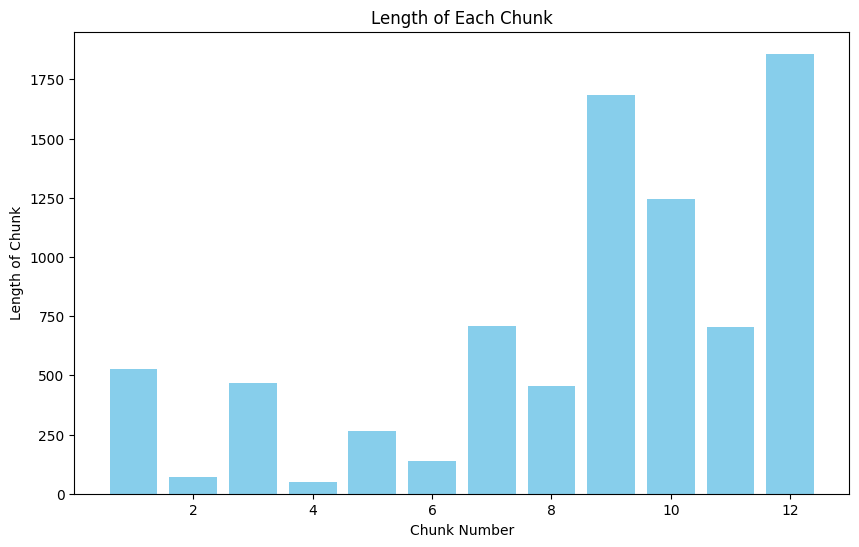

    Chunk 1  Chunk 2  Cosine Similarity
0         1        2           0.243364
1         1        3           0.745994
2         1        4           0.337336
3         1        5           0.400981
4         1        6           0.715013
..      ...      ...                ...
61        9       11           0.332291
62        9       12           0.416627
63       10       11           0.346821
64       10       12           0.417015
65       11       12           0.764760

[66 rows x 3 columns]


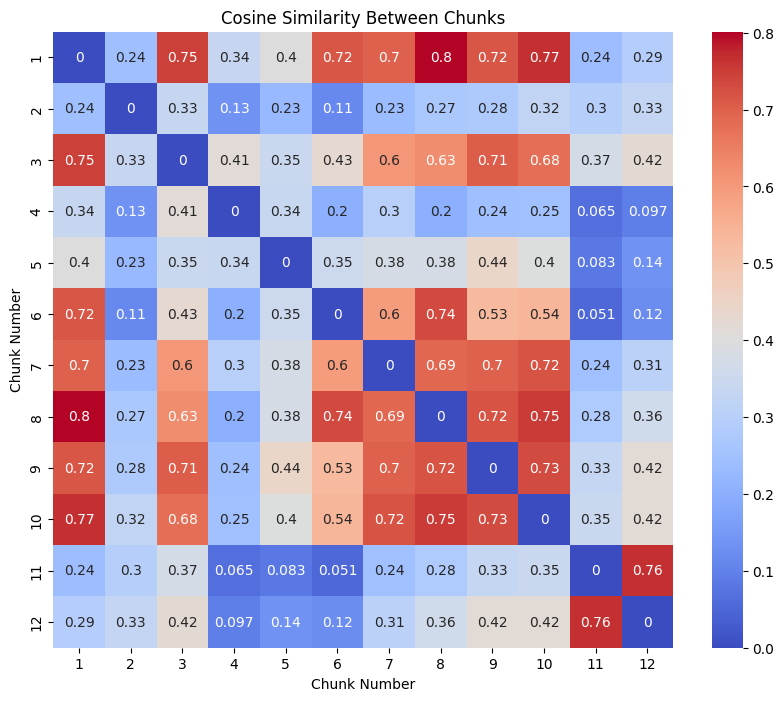

In [117]:
import pandas as pd
import seaborn as sns

input_text = """
Chính phủ đề xuất lập Quỹ Hỗ trợ đầu tư với các chính sách mạnh hơn để giữ chân, thu hút các tập đoàn lớn trong lĩnh vực bán dẫn, AI khi áp dụng thuế tối thiểu toàn cầu.

Chiều 11/12, Ủy ban Thường vụ thảo luận dự thảo Nghị định về thành lập, quản lý và sử dụng Quỹ Hỗ trợ đầu tư. Thứ trưởng Kế hoạch & Đầu tư Nguyễn Thị Bích Ngọc cho biết hiện thu hút đầu tư của Việt Nam dựa trên chính sách ưu đãi, hỗ trợ đầu tư theo lĩnh vực, địa bàn khuyến khích rót vốn. Mức ưu đãi cụ thể áp dụng theo quy định về thuế, kế toán và đất đai.

Bà Ngọc cho rằng chính sách như vậy có tính cạnh tranh trong khu vực. Nhưng chính sách còn dàn trải, chưa bắt kịp với thông lệ quốc tế, đặc biệt không còn tác dụng trong thu hút dự án lớn, tập đoàn đa quốc gia khi áp dụng thuế tối thiểu toàn cầu. Tức là, Việt Nam cần chính sách hỗ trợ đầu tư mới hướng đến các dự án quy mô lớn, có sức lan tỏa trong lĩnh vực công nghệ cao thông qua Quỹ hỗ trợ đầu tư, để tạo đột phá, đảm bảo vị thế cạnh tranh, cũng như giữ chân và thu hút các tập đoàn lớn khi áp dụng thuế thu nhập tối thiểu toàn cầu.

Việt Nam áp thuế tối thiểu toàn cầu từ đầu 2024. Mức thuế suất là 15% cho các doanh nghiệp đa quốc gia có tổng doanh thu hợp nhất từ 750 triệu euro (khoảng 800 triệu USD) trở lên trong hai năm của 4 năm liền kề nhất. Khoảng 122 tập đoàn đầu tư nước ngoài phải nộp thuế này ở Việt Nam, theo rà soát của cơ quan thuế.

Theo đề xuất của Chính phủ, Quỹ Hỗ trợ đầu tư do Chính phủ lập, giao Bộ Kế hoạch & Đầu tư quản lý và hoạt động không vì mục tiêu lợi nhuận.

Quỹ này sử dụng ngân sách và các nguồn ngoài ngân sách (tài trợ, viện trợ, dư quỹ hàng năm...). Với nguồn từ ngân sách, quỹ lấy từ số thu thuế thu nhập doanh nghiệp bổ sung theo quy định chống xói mòn cơ sở thuế toàn cầu, khoảng 14.600 tỷ đồng tính tới cuối 2022, để chi hỗ trợ trực tiếp cho một số đối tượng ưu tiên.

Hàng năm ngân sách sẽ bố trí phân bổ khoản chi cho quỹ từ nguồn thu thực tế thuế thu nhập doanh nghiệp bổ sung này. Chẳng hạn, dự toán chi ngân sách của quỹ này từ năm 2027 sẽ được xây dựng trên số thực tế thu năm 2025.

Trường hợp quỹ không đủ tài chính, các bộ sẽ báo cáo Thủ tướng, Chính phủ trình cơ quan có thẩm quyền bổ sung dự toán năm hoặc quyết định bổ sung ngân sách theo quy định.

Thứ trưởng Kế hoạch & Đầu tư Nguyễn Thị Bích Ngọc phát biểu tại phiên họp chiều 11/12. Ảnh: Media Quốc hội

Quỹ Hỗ trợ đầu tư được tổ chức theo mô hình mới, tương tự một đơn vị sự nghiệp công lập nhưng có khác biệt. Cụ thể, quỹ này sẽ không cung cấp dịch vụ công, không có bộ máy riêng để quản lý và thực hiện các nhiệm vụ đặc thù trong chi hỗ trợ đầu tư. Hội đồng quản lý quỹ do Thủ tướng quyết định thành lập, nhiệm kỳ 5 năm và được xem xét bổ nhiệm lại. Cơ cấu, tổ chức của Hội đồng quản lý Quỹ thực hiện theo quyết định của Thủ tướng.

Liên quan tới chính sách hỗ trợ, theo Thứ trưởng Bích Ngọc, Quỹ Hỗ trợ đầu tư sẽ dành nguồn lực cho doanh nghiệp công nghệ cao (bán dẫn, AI...), đơn vị có dự án đầu tư sản xuất sản phẩm hoặc ứng dụng công nghệ cao; dự án đầu tư trung tâm nghiên cứu và phát triển (R&D).

Để được hỗ trợ, doanh nghiệp cần có dự án đầu tư sản xuất sản phẩm, ứng dụng công nghệ cao, với vốn tối thiểu 12.000 tỷ đồng hoặc doanh thu ít nhất 20.000 tỷ đồng một năm.

Doanh nghiệp có dự án trong lĩnh vực công nghiệp chip, mạch tích hợp bán dẫn, trung tâm dữ liệu AI cần có vốn tối thiểu 6.000 tỷ đồng hoặc doanh thu 10.000 tỷ đồng một năm.

Tiêu chí về vốn, doanh thu tối thiểu mỗi năm sẽ không áp dụng với doanh nghiệp có dự án đầu tư sản xuất sản phẩm, ứng dụng công nghệ cao thuộc danh mục công nghệ, sản phẩm đột phá được ưu tiên nghiên cứu, phát triển và đơn vị có dự án thiết kế vi mạch.

Khoản hỗ trợ từ quỹ này sẽ được chi trực tiếp bằng tiền và qua các hạng mục hỗ trợ:

Hạng mục chi phí hỗ trợ	Tỷ lệ hỗ trợ
Đào tạo, phát triển nhân lực	50% mức chi thực tế dự án
Đầu tư tạo tài sản cố định	tối đa 10%; không quá 0,5% tổng vốn đầu tư mỗi năm
Sản xuất sản phẩm công nghệ cao	tối đa 3% giá trị sản xuất gia tăng sản phẩm
Đầu tư công trình hạ tầng xã hội	tối đa 25% các loại chi phí đầu tư
Riêng với nhà đầu tư mới có dự án trung tâm R&D trong lĩnh vực công nghiệp bán dẫn, AI có thể được hỗ trợ chi phí ban đầu cao nhất 50%.

Thẩm tra nội dung này, ông Lê Quang Mạnh, Chủ nhiệm Ủy ban Tài chính ngân sách đề nghị Chính phủ cân nhắc việc hỗ trợ này dành cho cả doanh nghiệp trong nước, thay vì chỉ riêng công ty nước ngoài.

Dự thảo nghị định đưa ra nhiều hình thức hỗ trợ với các tỷ lệ khác nhau và một số khoản hỗ trợ theo mức tối đa. Theo Thường trực Ủy ban Tài chính ngân sách, các hạng mục hỗ trợ chi phí là rất rộng, song chưa rõ nguyên tắc, tiêu chí nào phân chia như vậy. Do đó, để hạn chế rủi ro cơ quan này đề nghị Chính phủ nên có một mức trần hỗ trợ tối đa với từng loại doanh nghiệp và cân đối với tổng nguồn lực của quỹ.

Việc này nhằm tránh rơi vào tình trạng tổng số tiền hỗ trợ quá cao, vượt khả năng đáp ứng của Quỹ và không tương xứng với đóng góp thực tế của từng doanh nghiệp. Với các nhà đầu tư mới được hỗ trợ chi phí ban đầu, Ủy ban Tài chính ngân sách đề nghị làm rõ nội hàm của chi phí ban đầu là gì, tính trong thời gian bao lâu.

"Một số khoản hỗ trợ được quy định trong dự thảo theo mức tối đa sẽ dễ tạo ra cơ chế thực hiện không chuẩn mực", ông Mạnh nói, thêm rằng Chính phủ cũng cần bổ sung quy định về trách nhiệm, cách xử lý khi tổ chức, cá nhân xét duyệt hỗ trợ sai, vi phạm trong quản lý, sử dụng Quỹ.Những lỗi hay gặp khi giao tiếp tiếng Anh
Phản xạ chậm: nhiều người khi giao tiếp, đứng trước 1 câu hỏi phải mất nhiều thời gian để hiểu được ý của người nói và tìm cách phản hồi lại. Đây là 1 điều rất nên tránh trong giao tiếp thực tế. Có nhiều lý do cho việc này

Kỹ năng nghe chưa tốt, không theo kịp tốc độ thực tế và ngữ điệu của người nói. Điều này khiến người học bỏ lỡ thông tin quan trọng hoặc không hiểu rõ ngữ cảnh. Nguyên nhân có thể là do chưa nghe tiếng Anh đủ thường xuyên, chưa làm quen với nhiều giọng điệu khác nhau như Anh-Anh, Anh-Mỹ, hoặc các accent đặc thù khác.
Phát âm không rõ ràng: Do sự khác biệt về cấu trúc ngôn ngữ, nên có nhiều âm tiếng Anh sẽ khó phát âm với người Việt, ví dụ như ending sound /t/,/d/,/z/,…Vì thế, chúng ta rất dễ phát âm sai khi giao tiếp, nếu không luyện tập thường xuyên. Điều này dẫn đến việc người nghe không hiểu được nội dung bạn muốn truyền tải, thậm chí là làm bạn cảm thấy mất tự tin.
Thiếu từ vựng để diễn đạt điều mình muốn nói. Từ đó dẫn đến việc không diễn đạt được ý tưởng chính xác hoặc phải sử dụng những cách nói vòng vo, gây khó hiểu cho người nghe. Đặc biệt, khi đối mặt với các tình huống đòi hỏi vốn từ chuyên ngành hoặc cụ thể, người học dễ lúng túng và mất tự tin. Điều này thường xuất phát từ việc học từ vựng không có hệ thống hoặc không thường xuyên ôn tập.
Không thường xuyên thực hành tiếng Anh nên mất nhiều thời gian tư duy để tìm cách nói thích hợp. Điều này dẫn đến tình trạng phải suy nghĩ lâu trước khi nói, làm mất nhịp giao tiếp tự nhiên. Bên cạnh đó, nỗi sợ mắc lỗi cũng khiến nhiều người ngại thực hành, dẫn đến vòng luẩn quẩn: ít nói -> phản xạ chậm -> thiếu tự tin.
 8 cách tự học tiếng Anh giao tiếp hiệu quả
Để tự học giao tiếp tiếng Anh đạt hiệu quả cao nhất và tránh được các lỗi trong giao tiếp tiếng Anh đã đề cập ở trên, các bạn có thể tham khảo 8 cách tự học dưới đây.

Luyện sử dụng từ vựng theo chủ đề
Để phản xạ nhanh và diễn đạt hay hơn khi giao tiếp, các bạn nên chuẩn bị cho mình 1 vốn từ vựng theo các chủ đề. Học từ vựng theo chủ đề giúp các từ có sự kết nối với nhau, vừa dễ nhớ, và bạn không cần mất thời gian đắn đo liệu từ vựng này có phù hợp sử dụng trong hoàn cảnh này không.

Ngoài học từ vựng theo chủ đề, việc ôn tập lại và thường xuyên sử dụng chúng cũng là yếu tố quan trọng quyết định phản xạ tiếng Anh của bạn. Để quá trình này tối ưu và hiệu quả nhất, các bạn có thể sử dụng công cụ hỗ trợ học từ vựng MochiVocab. Đây là 1 ứng dụng học từ vựng ứng dụng phương pháp Spaced Repetition – Lặp lại ngắt quãng

Spaced Repetition là 1 phương pháp khoa học đã được kiểm chứng và được sử dụng trên toàn thế giới giúp tăng khả năng ghi nhớ. Theo phương pháp này, các từ vựng cần học sẽ được chia nhỏ ra và ôn tập lặp lại vào những khoảng thời gian cách quãng, lúc mà bạn sắp quên đi từ vựng đó.
"""

chunks = chunk_text(input_text, 80)
for i, chunk in enumerate(chunks, 1):
    print(f"Chunk {i}:")
    print(chunk)
    print("----------------------------------------------------------------------------")

print(f"\nTotal number of chunks: {len(chunks)}")
import matplotlib.pyplot as plt

# Calculate the length of each chunk
chunk_lengths = [len(chunk) for chunk in chunks]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(chunks) + 1), chunk_lengths, color='skyblue')
plt.xlabel('Chunk Number')
plt.ylabel('Length of Chunk')
plt.title('Length of Each Chunk')
plt.show()
# Calculate cosine similarities between each pair of chunks
cosine_similarities = []
for i in range(len(chunks)):
    for j in range(i + 1, len(chunks)):
        similarity = cosine_similarity([get_embeddings([chunks[i]])[0]], [get_embeddings([chunks[j]])[0]])[0][0]
        cosine_similarities.append((i + 1, j + 1, similarity))

# Create a dataframe to display the cosine similarities

cosine_df = pd.DataFrame(cosine_similarities, columns=['Chunk 1', 'Chunk 2', 'Cosine Similarity'])
print(cosine_df)

# Create a heatmap for cosine similarities

cosine_matrix = np.zeros((len(chunks), len(chunks)))
for i, j, similarity in cosine_similarities:
    cosine_matrix[i - 1, j - 1] = similarity
    cosine_matrix[j - 1, i - 1] = similarity

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_matrix, annot=True, cmap='coolwarm', xticklabels=range(1, len(chunks) + 1), yticklabels=range(1, len(chunks) + 1))
plt.xlabel('Chunk Number')
plt.ylabel('Chunk Number')
plt.title('Cosine Similarity Between Chunks')
plt.show()